In [105]:
import nltk
import time
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from contextlib import contextmanager
import random
import csv
import pandas as pd
import json

In [19]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [5]:
lda_data = pd.read_csv('doc_topic50.csv')

In [6]:
lda_data = lda_data.set_index('comment_text')

In [7]:
x = lda_data.iloc[:,1:]
y = lda_data.iloc[:, 0]

In [10]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [100]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)
x_balance, y_balance = RandomOverSampler().fit_sample(x_train, y_train)
x_balance = pd.DataFrame(x_balance, columns=x_train.columns)

In [101]:
lr.fit(x_balance, y_balance)
y_pred = lr.predict(x_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [71]:
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

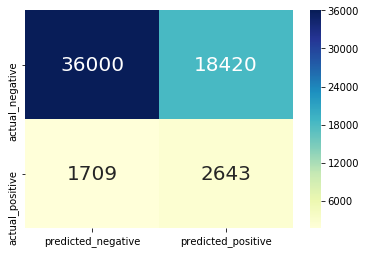

In [72]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred)

In [73]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_TFIDF']
results

,LogReg_TFIDF
Accuracy,0.658
Precision,0.125
Recall,0.607
F1 Score,0.207


,LogReg_TFIDF,NB_TFIDF
Accuracy,0.658,0.508
Precision,0.125,0.099
Recall,0.607,0.699
F1 Score,0.207,0.173


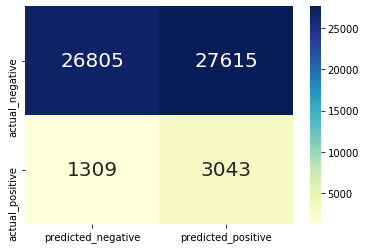

In [74]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_balance, y_balance)
y_pred_nb = bnb.predict(x_test)

# Here's the heat map for the first Naive Bayes model
cm2 = conf_matrix(y_test, y_pred_nb)

# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_TFIDF', 'NB_TFIDF']
results

[timer] start.


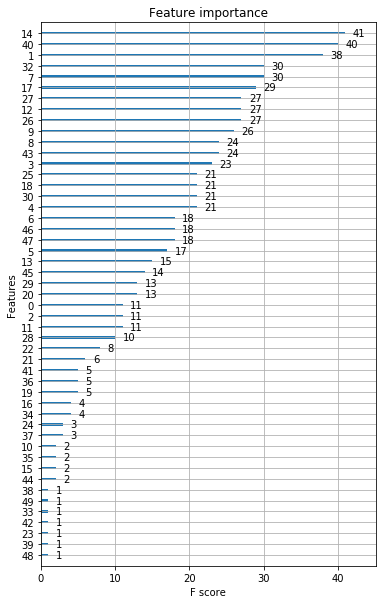

ROC_AUC:  0.639310832346996
[[36683 17737]
 [ 1721  2631]]
[timer] done in 0.79 min.


In [75]:
with timer('timer'):
    model = XGBClassifier()
    model.fit(x_balance, y_balance)
    # plot feature importance
    ax = plot_importance(model)
    fig = ax.figure
    fig.set_size_inches(6, 10)
    pyplot.show()
    predict = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("ROC_AUC: ", roc_auc)
    print(confusion_matrix(y_test, predict))

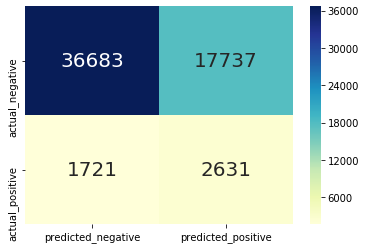

In [76]:
cm3 = conf_matrix(y_test, predict)

In [77]:
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec
Accuracy,0.658,0.508,0.669
Precision,0.125,0.099,0.129
Recall,0.607,0.699,0.605
F1 Score,0.207,0.173,0.213


In [83]:
x.shape

(235087, 50)

In [84]:
y.shape

(235087,)

In [82]:
import keras

Using TensorFlow backend.


In [113]:
deep_model = keras.Sequential([
    keras.layers.Dense(units=200, input_shape=(50, ), name="hidden_layer"),
    keras.layers.Activation("relu", name="1_activation"),
    keras.layers.Dense(units=100, name="2_layer"),
    keras.layers.Activation("relu", name="2_activation"),
    keras.layers.Dense(units=50, name="3_layer"),
    keras.layers.Activation("relu", name="3_activation"),
    keras.layers.Dense(units=20, name="4_layer"),
    keras.layers.Activation("relu", name="4_activation"),
    keras.layers.Dense(units=10, name="5_layer"),
    keras.layers.Activation("relu", name="5_activation"),
    keras.layers.Dense(units=1, name="output_layer"),
    keras.layers.Activation("sigmoid", name="sigmoid_activation"),
    
])

deep_model.compile(optimizer="nadam", loss="binary_crossentropy", metrics=["binary_accuracy"])

deep_model.fit(x_balance,y_balance, epochs=5)

Epoch 1/5
326522/326522 [==============================] - 15s 46us/step - loss: 0.6261 - binary_accuracy: 0.6468
Epoch 2/5
326522/326522 [==============================] - 15s 45us/step - loss: 0.5832 - binary_accuracy: 0.6871
Epoch 3/5
326522/326522 [==============================] - 15s 45us/step - loss: 0.5263 - binary_accuracy: 0.7334
Epoch 4/5
326522/326522 [==============================] - 14s 44us/step - loss: 0.4725 - binary_accuracy: 0.7704
Epoch 5/5
326522/326522 [==============================] - 14s 43us/step - loss: 0.4289 - binary_accuracy: 0.7983


In [137]:
predict = deep_model.predict(x_test)

In [138]:
predict = np.where(predict >= 0.4, 1, 0)

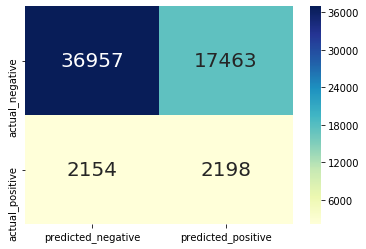

In [139]:
cm4 = conf_matrix(y_test, predict)

In [140]:
results = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec', 'KerasClassifier']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec,KerasClassifier
Accuracy,0.658,0.508,0.669,0.666
Precision,0.125,0.099,0.129,0.112
Recall,0.607,0.699,0.605,0.505
F1 Score,0.207,0.173,0.213,0.183
